In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [4]:
# compute the azimuthal correlations

roots = 100

pT_values = np.linspace(0.5, 10, 20)
djs = {}

djs['pp'] = dijet.DIJET(fit_type='pp', constrained_moments=False)
djs['dis'] = dijet.DIJET(fit_type='dis', constrained_moments=False)
fits = ['dis', 'pp']

replicas = {}

for key in fits:
    replicas[key] = []

space = {
    'y' : [0.05, 0.95],
    'z' : [0.2, 0.5],
    'Q2': [16, 100],
    't' : [0.05, 0.1],
    'phi_Dp': [0, 2*np.pi],
    'phi_kp': [0, 2*np.pi]
}
replicas['space'] = space
replicas['pT values'] = pT_values
replicas['roots'] = roots

npoints = 8
nreps = 100

denom = djs[fits[0]].get_integrated_xsec(pT_values, roots**2, space, points=npoints, kind='den', r0=2.0)
for irep in range(1, nreps):
    for ifit, fit in enumerate(fits):
        djs[fit].set_params(irep)
    
        rep = {}
        rep['<1>'] = djs[fit].get_integrated_xsec(pT_values, roots**2, space, weight='1', points=npoints, kind='num', r0=2.0)/denom
        rep['<cos(phi_Dp)>'] = djs[fit].get_integrated_xsec(pT_values, roots**2, space, weight='cos(phi_Dp)', points=npoints, kind='num', r0=2.0)/denom
        rep['<cos(phi_Dp)cos(phi_kp)>'] = djs[fit].get_integrated_xsec(pT_values, roots**2, space, weight='cos(phi_Dp)cos(phi_kp)', points=npoints, kind='num', r0=2.0)/denom
        rep['<sin(phi_Dp)sin(phi_kp)>'] = djs[fit].get_integrated_xsec(pT_values, roots**2, space, weight='sin(phi_Dp)sin(phi_kp)', points=npoints, kind='num', r0=2.0)/denom
        rep['denom'] = denom
    
        replicas[fit].append(rep)

    np.save('data/dsa_corr_oam3_range10.npy', replicas, allow_pickle=True)


--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10.csv
--> loaded replica 1
--> loaded replica 1
--> loaded replica 2
--> loaded replica 3
--> loaded replica 4
--> loaded replica 5
--> loaded replica 6
--> loaded replica 7
--> loaded replica 8
--> loaded replica 9
--> loaded replica 10
--> loaded replica 11
--> loaded replica 12
--> loaded replica 13
--> loaded replica 14
--> loaded replica 15
--> loaded replica 16
--> loaded replica 17
--> loaded replica 18
--> loaded replica 19
--> loaded replica 20
--> loaded replica 21
--> loaded replica 22
--> loaded replica 23
--> loaded replica 24
--> loaded replica 25
--> loaded replica 26
--> loaded replica 27
--> loaded replica 28
--> loaded replica 29
--> loaded replica 30
--> loaded replica 31
--

In [5]:
# calculate bands for correlations

corr_data = np.load('data/dsa_corr_oam3_range10.npy', allow_pickle=True).item()

confid = 68

fits = ['+pp(constrained)']

for fit in fits:
    for irep in range(len(corr_data[fit])):
        corr_data[fit][irep]['<cos(phi_Dp + phi_kp)>'] = corr_data[fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] - corr_data[fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
        corr_data[fit][irep]['<cos(phi_Dp - phi_kp)>'] = corr_data[fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] + corr_data[fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
    

corr_bands = {}

for fit in fits:
    corr_bands[fit] = {}
    for obj in ['lower', 'upper', 'mean']:
        corr_bands[fit][obj] = {}

    for corr in ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']:
        corr_reps = [rep[corr] for rep in corr_data[fit]]
        corr_bands[fit]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0)
        corr_bands[fit]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0)
        corr_bands[fit]['mean'][corr] = np.mean(corr_reps, axis=0)


lumi = 100
all_error = np.sqrt(1/(2*lumi*np.array(corr_data[fits[0]][0]['denom'])))
tt_error = np.sqrt(2.0/(2*lumi*np.array(corr_data[fits[0]][0]['denom'])))
lt_error = np.sqrt(4.0/(2*lumi*np.array(corr_data[fits[0]][0]['denom'])))

print(tt_error)

# get kinematics + make labels
space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])
 
pT_values = replicas['pT values']
roots = replicas['roots']

# info_text = fr'Integrated lumi.: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
# info_text = fr'$\int L dt \, = {lumi}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'

for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


[0.00016978 0.0001416  0.00014736 0.00016892 0.00020052 0.00024078
 0.00029304 0.00035971 0.00043666 0.00052248 0.00062769 0.00075649
 0.00089309 0.00103697 0.00121757 0.00143365 0.00163978 0.00185287
 0.00214063 0.00246897]


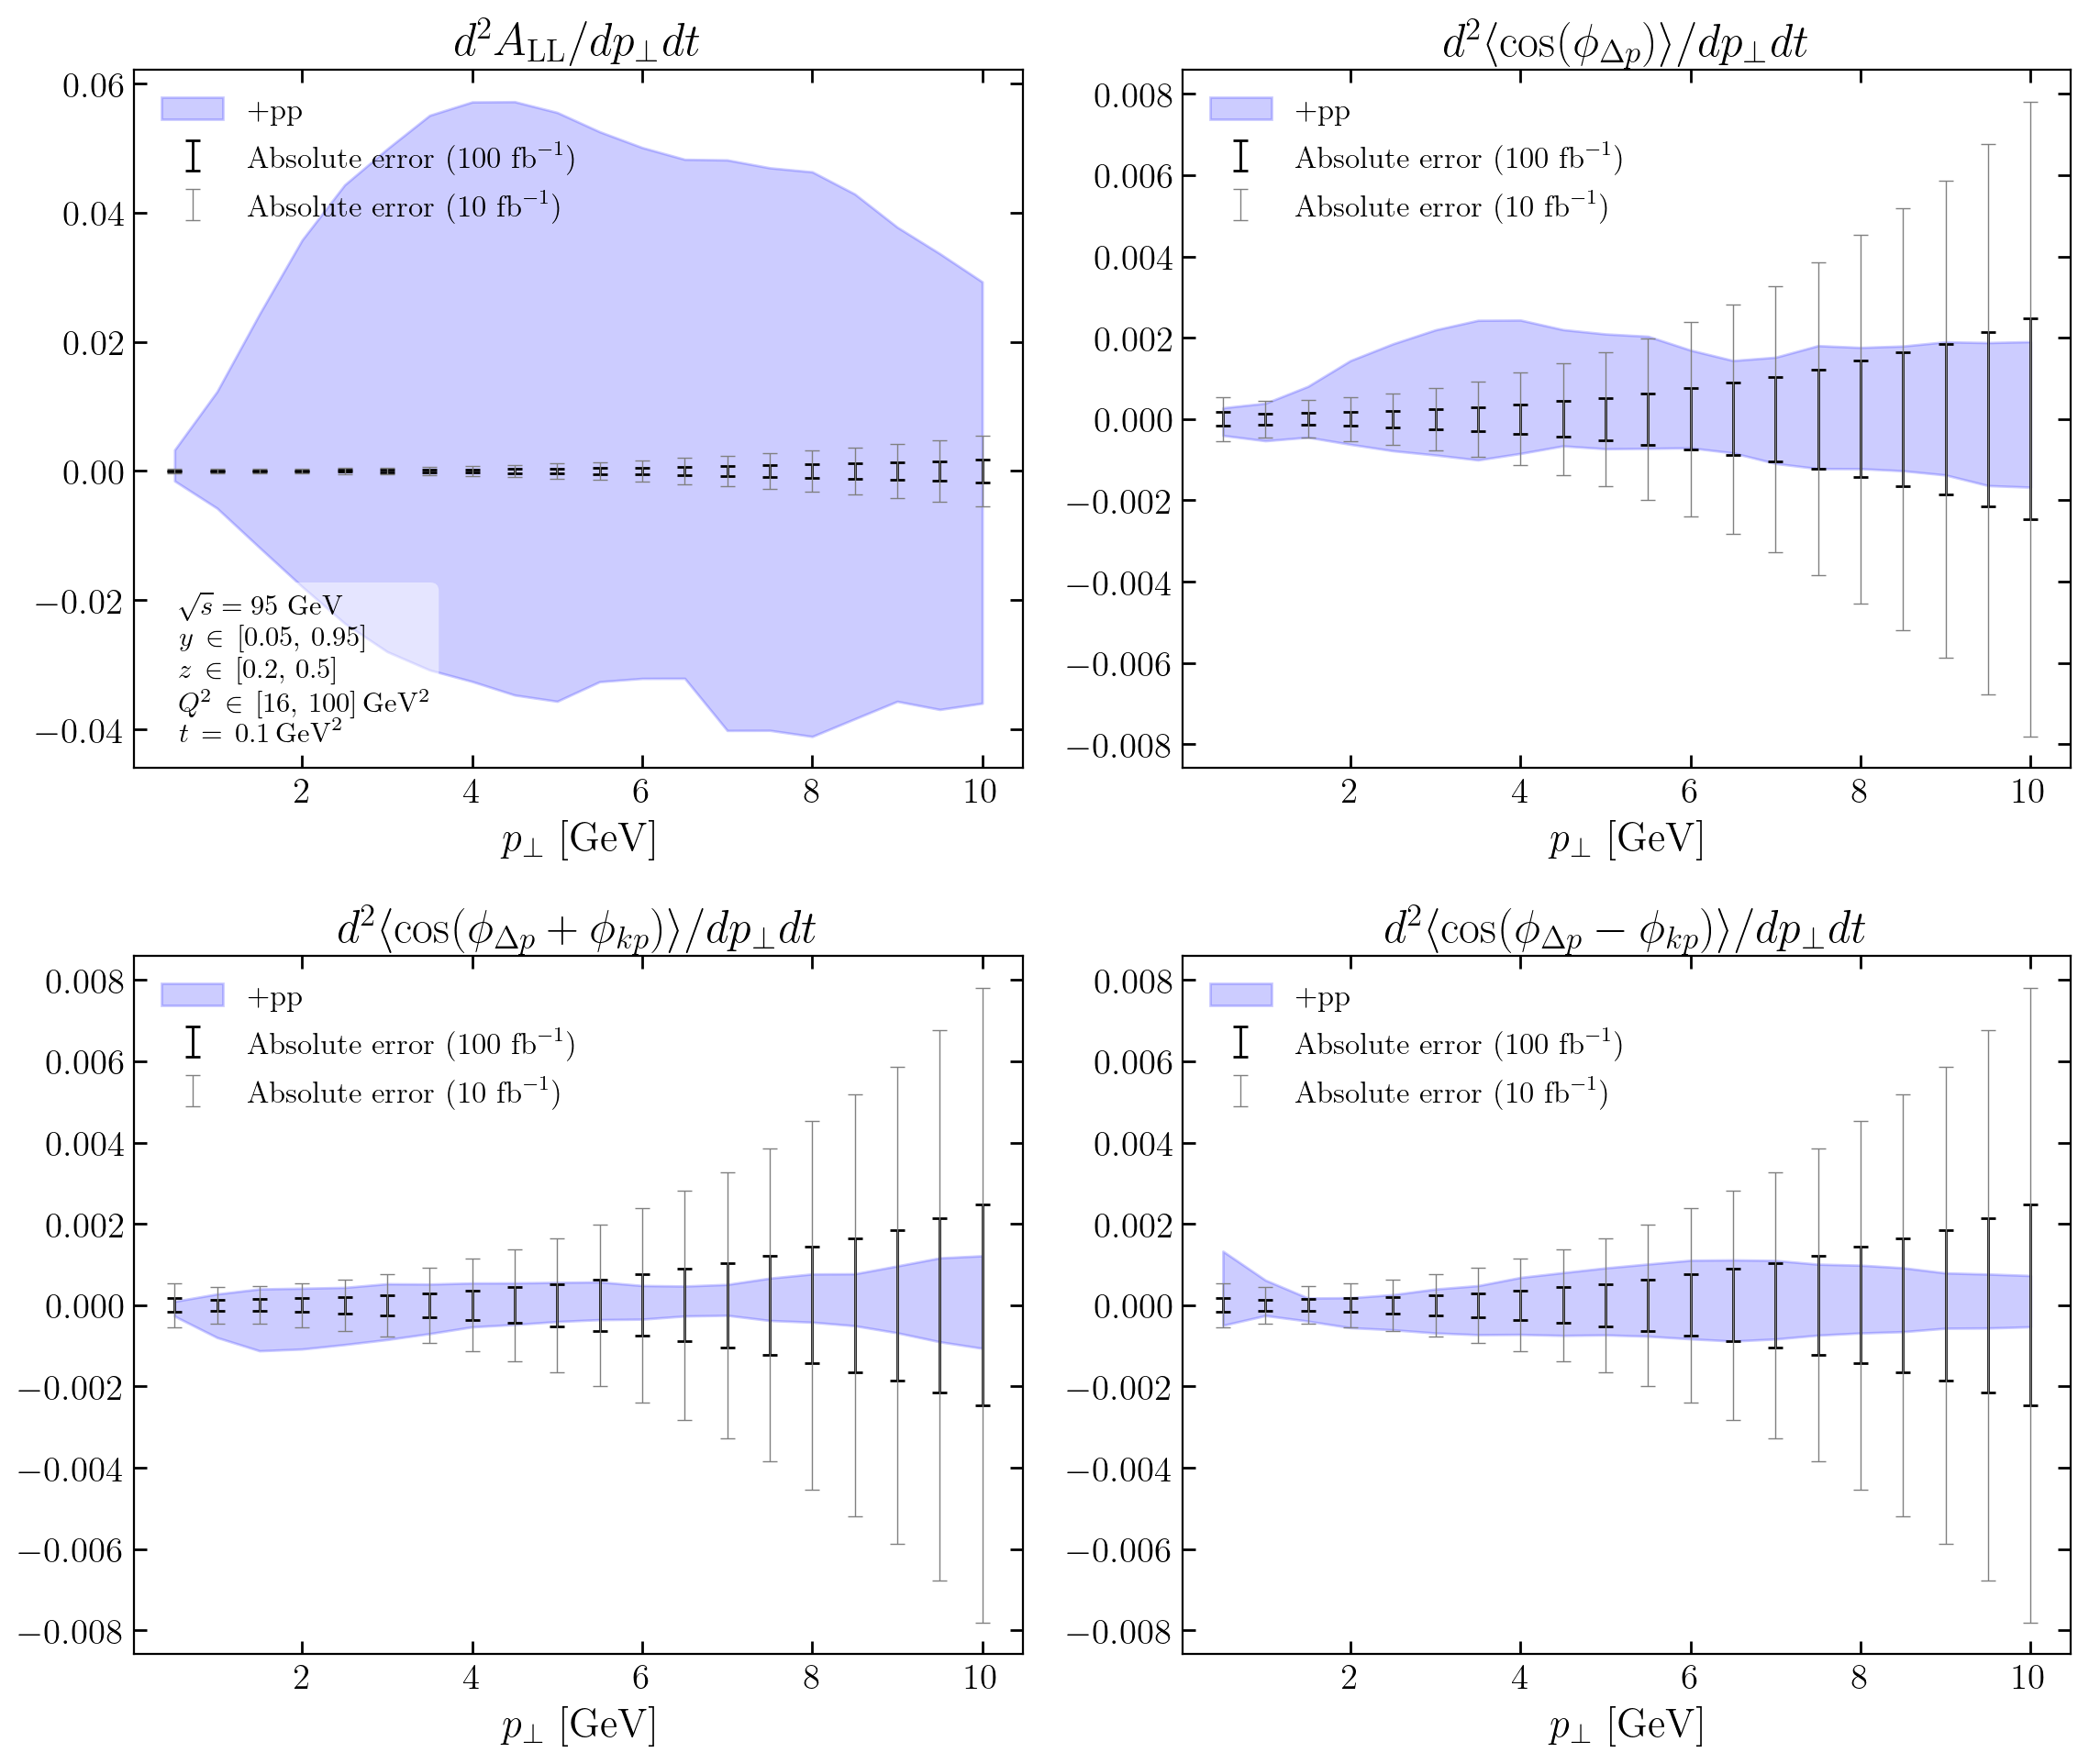

In [6]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

plot_bands = True
alt_defs = True

colors = ['blue']
# labels = ['DIS+SIDIS', '+pp']
# labels = ['+pp', '+pp (reasonable moments)']
labels = ['+pp']

corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
if alt_defs: 
    corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

for ifit, fit in enumerate(fits):
    
    for icorr, corr in enumerate(corrs):

        if plot_bands:
            # axs[icorr].plot(pT_values, corr_bands[fit]['mean'][corr], color=colors[ifit])
            axs[icorr].fill_between(pT_values, corr_bands[fit]['lower'][corr], corr_bands[fit]['upper'][corr], color=colors[ifit], alpha=0.2, label=labels[ifit])
        
        else:
            for irep, rep in enumerate(corr_data[fit]):
                if irep == 0:
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[ifit], label=labels[ifit])
                else: 
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[ifit])

        if ifit == 0:
            if alt_defs: errors = [all_error, tt_error, tt_error, tt_error]
            else: errors = [all_error, tt_error, lt_error, lt_error]

            axs[icorr].errorbar(
                    pT_values, np.zeros(all_error.shape), yerr=errors[icorr], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='black', markersize=0, 
                    label=rf'Absolute error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
            )
            axs[icorr].errorbar(
                    pT_values, np.zeros(all_error.shape), yerr=np.sqrt(10)*errors[icorr], fmt='o',
                    capsize=3, elinewidth=0.5, capthick=0.5, color='gray', markersize=0, 
                    label=rf'Absolute error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
            )


# axs[0].axhline(y=1, color='grey', linestyle=':')
# axs[0].axhline(y=-1, color='grey', linestyle=':')
# axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0].set_title(fr'$ d^{num_label} A_{{\mathrm{{LL}}}} / {den_label} $')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend(frameon=False)
axs[0].text(
    0.05, 0.03, info_text, 
    transform=axs[0].transAxes,
    ha='left', va='bottom', 
    fontsize=11, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none')
)
# axs[0].semilogy()
# axs[0].set_ylim([-0.1, 0.1])

# axs[1].axhline(y=0, color='lightgray', linestyle='-')
axs[1].set_xlabel(r'$p_\perp$ [GeV]')
axs[1].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}}) \rangle / {den_label} $')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[1].legend(frameon=False)
# axs[1].set_ylim([-0.005, 0.005])
# axs[1].semilogy()


# axs[2].axhline(y=0, color='gray', linestyle='-')
axs[2].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}} + \phi_{{k p}}) \rangle / {den_label} $')
else: 
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / {den_label} $')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[2].legend(frameon=False)
# axs[2].set_ylim([-0.004, 0.004])
# axs[2].semilogy()

# axs[3].axhline(y=0, color='gray', linestyle='-')
axs[3].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[3].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}} - \phi_{{k p}})  \rangle / {den_label} $')
else:
    axs[3].set_title(fr'$ d^{num_label} \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle / {den_label} $')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[3].legend(frameon=False)
# axs[3].set_ylim([-0.004, 0.004])
# axs[3].semilogy()
# axs[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# if plot_bands:
#     fig.savefig('plots/corr_band_dt_oam3_range10.pdf', dpi=400, bbox_inches="tight")
# else:
#     fig.savefig('plots/corr_lines_dt_oam3_range10.pdf', dpi=400, bbox_inches="tight")


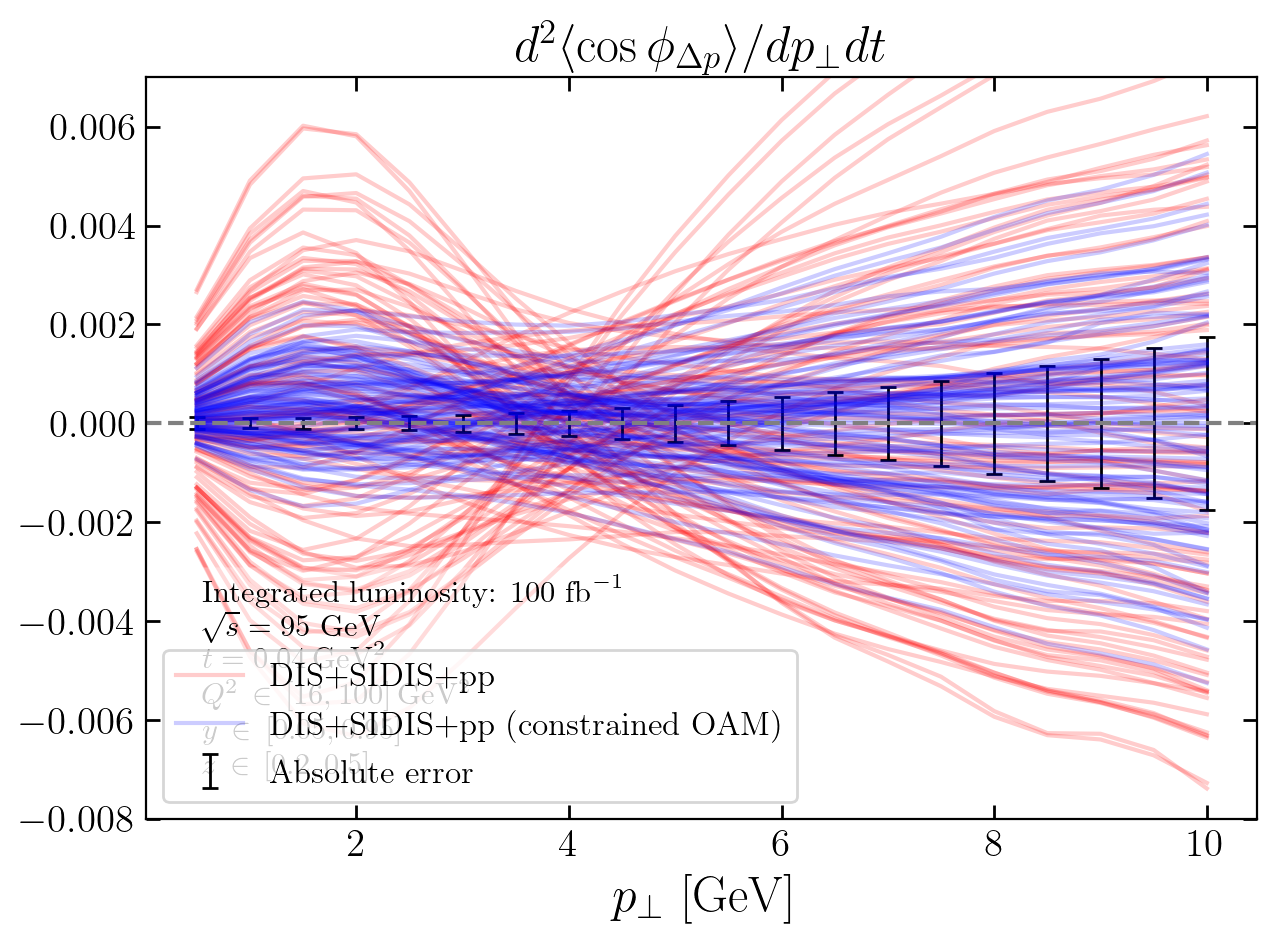

In [51]:
# QCD evo plot

# plot azimuthal correlations
asp_ratio = 4/3
psize = 5

space = {
    'y' : [0.05, 0.95],
    'z' : [0.2, 0.5],
    'min Q2' : 5,
    't' : [0.01, 0.04],
    # 'max Q2' : 30
}

pT_values = np.linspace(0.5, 10, 20)
fig, ax = plt.subplots(1, 1, figsize=(asp_ratio*psize, psize))

plot_bands = False

colors = ['red', 'blue']
# labels = ['DIS+SIDIS', '+pp']
labels = ['DIS+SIDIS+pp', 'DIS+SIDIS+pp (constrained OAM)']

for ifit, fit in enumerate(fits):
    
    for icorr, corr in enumerate(corr_data[fit][0].keys()):
        if icorr != 1: continue

        if plot_bands:
            # axs[icorr].plot(pT_values, corr_bands[fit]['mean'][corr], color=colors[ifit])
            ax.fill_between(pT_values, corr_bands[fit]['lower'][corr], corr_bands[fit]['upper'][corr], color=colors[ifit], alpha=0.2, label=labels[ifit])
        
        else:
            for irep, rep in enumerate(corr_data[fit]):
                if irep == 0:
                    ax.plot(pT_values, rep[corr], alpha=0.2, color=colors[ifit], label=labels[ifit])
                else: 
                    ax.plot(pT_values, rep[corr], alpha=0.2, color=colors[ifit])

        if ifit == 0:
            errors = [all_error, tt_error, lt_error, lt_error]

            ax.errorbar(
                    pT_values, np.zeros(all_error.shape), yerr=errors[icorr], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='black', markersize=0, 
                    label=rf'Absolute error'
            )



ax.axhline(y=0, color='grey', linestyle='--')
ax.set_xlabel(r'$p_{\perp}$ [GeV]', fontsize=18)
ax.set_title(r'$ d^2  \langle \cos \phi_{\Delta p} \rangle / d  p_\perp  dt $')
ax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
ax.legend()
# axs[0].semilogy()
ax.set_ylim([-0.008, 0.007])

# make info box: 
info_text = fr'Integrated luminosity: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
info_text += fr'$\sqrt{{s}} = {round(roots)}\,\, \mathrm{{GeV}}$' + '\n'
info_text += r'$t = 0.04 \, \mathrm{{GeV}}^2$' + '\n'

info_text += fr'$Q^2 \, \in \,[16, 100]\, \mathrm{{GeV^2}}$' + '\n'
info_text += fr'$y \, \in \, [0.05, 0.95]$' + '\n'
info_text += fr'$z \, \in \, [0.2, 0.5]$'


ax.text(
    0.05, 0.05, info_text, 
    transform=ax.transAxes, 
    ha='left', va='bottom', 
    fontsize=11, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.3, edgecolor='none')
)


plt.tight_layout()
plt.show()


if plot_bands:
    fig.savefig('plots/cos_corr_dt_band.pdf', dpi=400, bbox_inches="tight")
else:
    fig.savefig('plots/cos_corr_dt_lines.pdf', dpi=400, bbox_inches="tight")
